<a href="https://colab.research.google.com/github/tsakailab/alpp/blob/main/colab/alpp_cnn_practice_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNNの転移学習

学習済みの特徴抽出器を流用する物体認識のCNNモデルを作ります．

## 【モデル作り】モデルを定義して生成します．

### 学習済みのCNNモデルをTorchvisionから入手します．

[If pretrained=True, returns a model pre-trained on ImageNet.](https://pytorch.org/vision/stable/models.html)

In [ ]:
import torch
from torchvision import models

#model_pretrained = models.alexnet(pretrained=True)
#model_pretrained = models.vgg16(pretrained=True)
model_pretrained = models.vgg16_bn(pretrained=True)

#model_pretrained = models.resnet50(pretrained=True)
#model_pretrained = models.googlenet(pretrained=True)
#model_pretrained = models.mobilenet_v3_small(pretrained=True)
#model_pretrained = models.efficientnet_b0(pretrained=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_pretrained.eval().to(device)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### 特徴抽出器を取得します．
特徴抽出器（`features`）の何層の出力を流用しますか？
層の番号を`features_at`，そこから出力される特徴マップのチャネル数を`nch`に設定してください．

```python
# 例1：vgg16_bn
(21): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
(22): ReLU(inplace=True)
(23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

# このReLUの出力を流用したければ，以下のように設定します．
features_at, n_channels = 22, 256

# 例2：vgg16_bnの特徴抽出器をまるごと流用するときは
features = model_pretrained.features
n_channels = 512
```



In [ ]:
features = model_pretrained.features # use the whole features
n_channels = 512

#features_at, n_channels = 22, 256
#features = model_pretrained.features[:features_at+1]

from torchsummary import summary
summary(features, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

### モデルを定義します．

In [ ]:
from torch import nn

class my_model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.classifier = nn.Sequential(
            nn.Linear(in_features=n_channels, out_features=num_classes)
        )
        #self.fc1 = nn.Linear(n_channels, num_classes)

    def forward(self,x):
        x = self.features(x)
        x = self.avgpool(x).squeeze(-1).squeeze(-1) # [B, C, H=1, W=1] -> [B, C]
        x = self.classifier(x)
        return x

### 定義どおりにモデルを生成できることを確認します．

`my_model`で生成すると共に，`to(device)`でGPUに転送します．

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

nclasses = 2
model = my_model(nclasses).to(device)

from torchsummary import summary
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
        MaxPool2d-14          [-1, 128,

## 【データの入手】教師あり学習に使う画像集合のzipファイルを指定します．
- `arcURL`: zipファイルの在処
- `dir['root']`: zipを展開すると作られるディレクトリ名
- `dir['train']`, `dir['val']`: 画像集合は`dir['root']`の中で訓練用と検証用に分けられているものとします．それらのディレクトリ名です．各ディレクトリの下には，クラス名のディレクトリがあり，クラス毎に画像が分けられているものとします．

In [ ]:
arcURL = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
dir = {'root': "./hymenoptera_data", 'train': "train", 'val': "val"}
#arcURL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
#dir = {'root': "./cats_and_dogs_filtered", 'train': "train", 'val': "validation"}
#arcURL = "https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz"

In [ ]:
#@title 画像集合をダウンロードします．
import os
!wget $arcURL --no-check-certificate --show-progress
from shutil import unpack_archive
unpack_archive(filename=os.path.basename(arcURL))

dir_names = os.listdir(os.path.join(dir['root'], dir['train']))

from glob import glob
for name, phase in zip(dir_names, ['train', 'val']):
    print(phase, name, len(glob(os.path.join(dir['root'], dir[phase], name, "*"))), "images")

--2021-12-08 09:22:38--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.160.98, 13.224.160.7, 13.224.160.39, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.160.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  67.0MB/s    in 0.7s    

2021-12-08 09:22:38 (67.0 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

train bees 121 images
val ants 70 images


## 【データを読み込む設定】モデルの入出力のため，DataLoaderを用意します．

`hparam`は，学習に関わる設定値で，予め与える必要がある[ハイパーパラメータ](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning))です．学習の結果や計算量が変わります．

`data_transformsは`，`dir['train']`と`dir['val']`にある訓練画像と検証画像の読み込み方を設定するためのdictionary（辞書）です．
- `dir['train']`に収められた画像をモデルの学習に用います．
- `dir['val']`にある画像は，訓練画像でない画像に対する識別の性能を観察するために用います．
- ImageNetの使用に倣って色を正規化します（`'mean_color'`と`'std_color'`）．
- データ拡張もここで定義します．例：`transforms.RandomHorizontalFlip()`
- 訓練画像集合は，`hparam['batch_size']`枚の**ミニバッチ（mini batch）**に小分けにして学習させます．

In [ ]:
hparam = {'batch_size': 64, 'image_size': (224, 224),
          'shuffle': True, 'num_workers': 2,
          'mean_color': [0.485, 0.456, 0.406], 'std_color': [0.229, 0.224, 0.225]}

from torchvision import transforms
data_transforms = {
    'train':
        transforms.Compose([
        transforms.Resize(hparam['image_size']),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(hparam['mean_color'], hparam['std_color'])
    ]),
    'val':
        transforms.Compose([
        transforms.Resize(hparam['image_size']),
        transforms.ToTensor(),
        transforms.Normalize(hparam['mean_color'], hparam['std_color'])
    ]),
}

In [ ]:
#@title DataLoader を作成します．
import torch
from torchvision import datasets
import os
image_datasets = {x: datasets.ImageFolder(os.path.join(dir['root'], dir[x]), data_transforms[x])
                  for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
categories = image_datasets['train'].classes
print("dataset sizes:", dataset_sizes, ", categories:", categories)

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=hparam['batch_size'],
                                              shuffle=hparam['shuffle'], num_workers=hparam['num_workers'])
               for x in ['train', 'val']}

dataset sizes: {'train': 244, 'val': 153} , categories: ['ants', 'bees']


Input batch of shape [B, C, H, W] = torch.Size([64, 3, 224, 224])


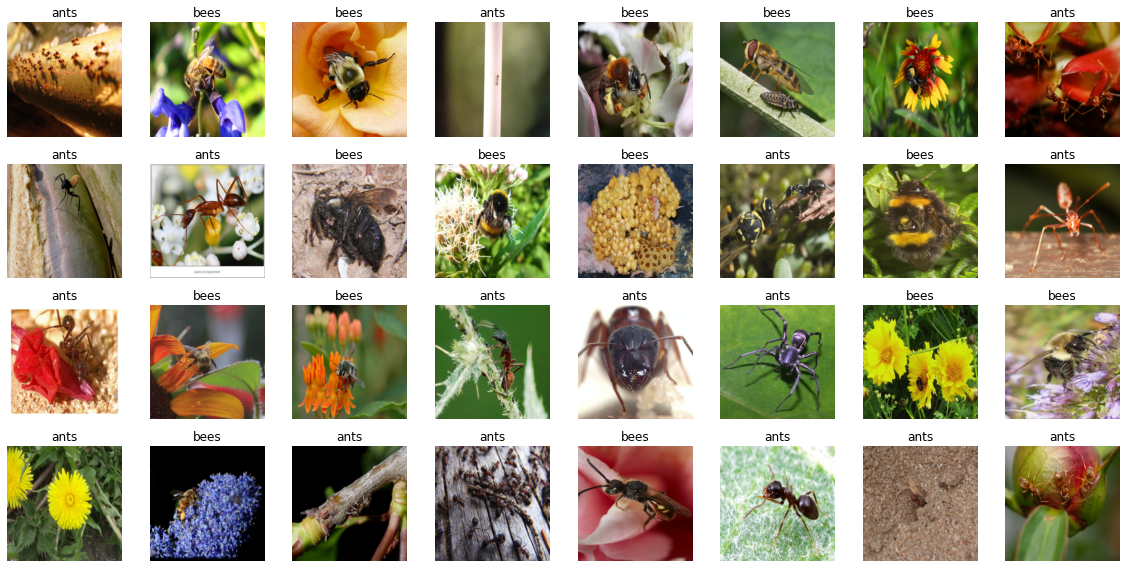

In [ ]:
#@title DataLoaderから取得した訓練画像のミニバッチの例を表示します．
import numpy as np
import matplotlib.pyplot as plt

def plotImages(img_arr, lbl_arr, colors_arr=None, figsize=(8, 4), mag=2, mean=0., std=1.):

    if len(img_arr) <= min(figsize): rc = (1, len(img_arr))
    else: rc = (figsize[1], min(len(img_arr)//figsize[1], figsize[0]))
    fig, axes = plt.subplots(rc[0], rc[1], figsize=(rc[1]*mag, rc[0]*mag))
    if len(img_arr) != 1:
        axes = axes.flatten()
    else: 
        axes = [axes]
    if colors_arr is None: colors_arr = ['k']*len(lbl_arr)
    for img, lbl, c, ax in zip( img_arr, lbl_arr, colors_arr, axes):
        img = img.numpy().transpose((1,2,0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(lbl, color=c)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

inputs, labels = next(iter(dataloaders['train']))
print("Input batch of shape [B, C, H, W] =", inputs.shape)
plotImages(inputs, [categories[l] for l in labels], mean=hparam['mean_color'], std=hparam['std_color'])

## モデルを生成し，学習可能にしないパラメータを設定します（※）

```python
# 例：特徴抽出器（features）だけ学習可能にしない（freeze）
for param in model.features.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True
```

`summary`で学習可能なパラメータ数 trainable params を確認してください．

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

nclasses = len(categories)
model = my_model(nclasses).to(device)

#model.requires_grad_(False)
for param in model.features.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

from torchsummary import summary
summary(model, (3, hparam['image_size'][0], hparam['image_size'][1]), batch_size=hparam['batch_size'])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 224, 224]           1,792
       BatchNorm2d-2         [64, 64, 224, 224]             128
              ReLU-3         [64, 64, 224, 224]               0
            Conv2d-4         [64, 64, 224, 224]          36,928
       BatchNorm2d-5         [64, 64, 224, 224]             128
              ReLU-6         [64, 64, 224, 224]               0
         MaxPool2d-7         [64, 64, 112, 112]               0
            Conv2d-8        [64, 128, 112, 112]          73,856
       BatchNorm2d-9        [64, 128, 112, 112]             256
             ReLU-10        [64, 128, 112, 112]               0
           Conv2d-11        [64, 128, 112, 112]         147,584
      BatchNorm2d-12        [64, 128, 112, 112]             256
             ReLU-13        [64, 128, 112, 112]               0
        MaxPool2d-14          [64, 128,

## 【学習の設定】[損失関数](https://pytorch.org/docs/stable/nn.html#loss-functions)と[最適化のアルゴリズム](https://pytorch.org/docs/stable/optim.html)を指定します．

モデルの学習とは，入力画像から正しく識別結果を出力できるようにモデルの学習可能パラメータ（Trainable parameters）を調整することです．出力の正しさは損失関数（loss function）で評価します．損失ができるだけ小さな値になるように学習可能パラメータを調整する計算の方法が最適化のアルゴリズムです．

最適化のアルゴリズムでは，学習可能パラメータを少しずつ修正して，損失関数を徐々に小さくします．この修正を反復した結果，訓練画像すべてに対して損失関数が十分に小さくなるような学習可能パラメータ（畳み込み層のカーネルや全結合層の重み）が求まります．

訓練画像集合のミニバッチ毎に学習可能パラメータは修正されます．最適化において，すべての訓練画像が一巡する回数をエポック（epoch）といいます．収束に必要なエポック数は数～数百で，最適化問題とアルゴリズムに依存します．

- 識別の評価には交差エントロピー損失関数[`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)を使います．モデルが識別結果を正しく出力できるほど，損失は小さいと評価します．
- 定番の最適化のアルゴリズムは[Adam](https://arxiv.org/abs/1412.6980)です．[`optim.Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)のオプション`lr`で学習率を設定します．
- 学習率とは，学習可能パラメータを修正する大きさの目安です．小さすぎると収束までに時間がかかります．大きすぎると損失関数が徐々に小さくならずに発散します．ハイパーパラメータ `hparam['learning_rate']`で指定します．
- エポック数もハイパーパラメータです．`hparam['epochs']`で指定します．

In [ ]:
criterion = nn.CrossEntropyLoss()

from torch import optim
hparam['learning_rate'] = 0.01
#optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=hparam['learning_rate'])
hparam['momentum'] = 0.9
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=hparam['learning_rate'], momentum=hparam['momentum'])

hparam['epochs'] = 16

In [ ]:
#@title 学習を実行する関数 run_training を定義します．
import time
import copy
 ## Define some function(training, printing result)
def run_training(model, criterion, optimizer, num_epochs=20):
    since = time.time()

    #best_model_wts = copy.deepcopy(model.state_dict())
    model_best = copy.deepcopy(model)
    best_acc = 0.0
    loss_dict = {'train': [], 'val': []}
    acc_dict = {'train': [], 'val': []}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double().cpu() / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)
            acc_dict[phase].append(epoch_acc)

            print('{} loss: {:.4f},  acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                #best_model_wts = copy.deepcopy(model.state_dict())
                model_best = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    #model_best.load_state_dict(best_model_wts)
    return model_best, loss_dict, acc_dict


## 【学習の実行】モデルを最適化します．

注意：とても時間がかかることがあります．この例では数分～数十分が目安です．停止ボタンで停止したときは，モデルの生成（※）のセルから実行し直してください．

- train loss が徐々に減少し，acc（0<=acc<=1）が上昇傾向ですか．
- train loss が増加，accが 下降傾向のときは lr が大きすぎです．
- train loss や accが ほとんど変化しないきは，lrが小さすぎです．

In [ ]:
model_best, loss_dict, acc_dict = run_training(model, criterion, optimizer, num_epochs=hparam['epochs'])

Epoch 0/15
----------
train loss: 0.7036,  acc: 0.4221
val loss: 0.6967,  acc: 0.5163

Epoch 1/15
----------
train loss: 0.6785,  acc: 0.6107
val loss: 0.6526,  acc: 0.7124

Epoch 2/15
----------
train loss: 0.6418,  acc: 0.7336
val loss: 0.6069,  acc: 0.8039

Epoch 3/15
----------
train loss: 0.5988,  acc: 0.8320
val loss: 0.5657,  acc: 0.9020

Epoch 4/15
----------
train loss: 0.5555,  acc: 0.8893
val loss: 0.5289,  acc: 0.9281

Epoch 5/15
----------
train loss: 0.5156,  acc: 0.9221
val loss: 0.4981,  acc: 0.9346

Epoch 6/15
----------
train loss: 0.4810,  acc: 0.9262
val loss: 0.4702,  acc: 0.9216

Epoch 7/15
----------
train loss: 0.4458,  acc: 0.9344
val loss: 0.4455,  acc: 0.9216

Epoch 8/15
----------
train loss: 0.4192,  acc: 0.9467
val loss: 0.4257,  acc: 0.9281

Epoch 9/15
----------
train loss: 0.4092,  acc: 0.9139
val loss: 0.4078,  acc: 0.9216

Epoch 10/15
----------
train loss: 0.3776,  acc: 0.9467
val loss: 0.3909,  acc: 0.9216

Epoch 11/15
----------
train loss: 0.3594,

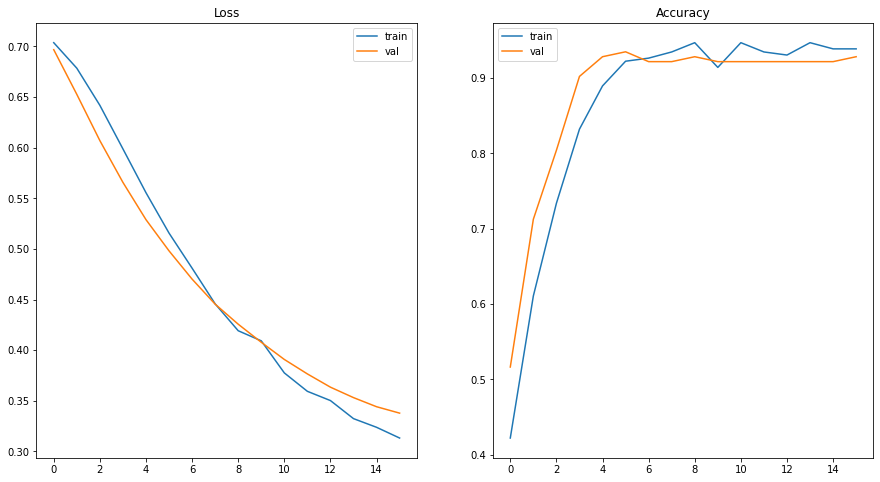

In [ ]:
#@title 学習の過程における損失関数と正答率の変化を表示します．
def plotting_history(loss_dict, acc_dict):
    epoch = len(loss_dict['train'])
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
    axes[0].plot(range(epoch), loss_dict['train'], label='train')
    axes[0].plot(range(epoch), loss_dict['val'], label='val')
    axes[0].set_title("Loss")
    axes[0].legend()

    axes[1].plot(range(epoch), acc_dict['train'], label='train')
    axes[1].plot(range(epoch), acc_dict['val'], label='val')
    axes[1].set_title("Accuracy")
    axes[1].legend()

plotting_history(loss_dict, acc_dict)

(ground truth, prediction)


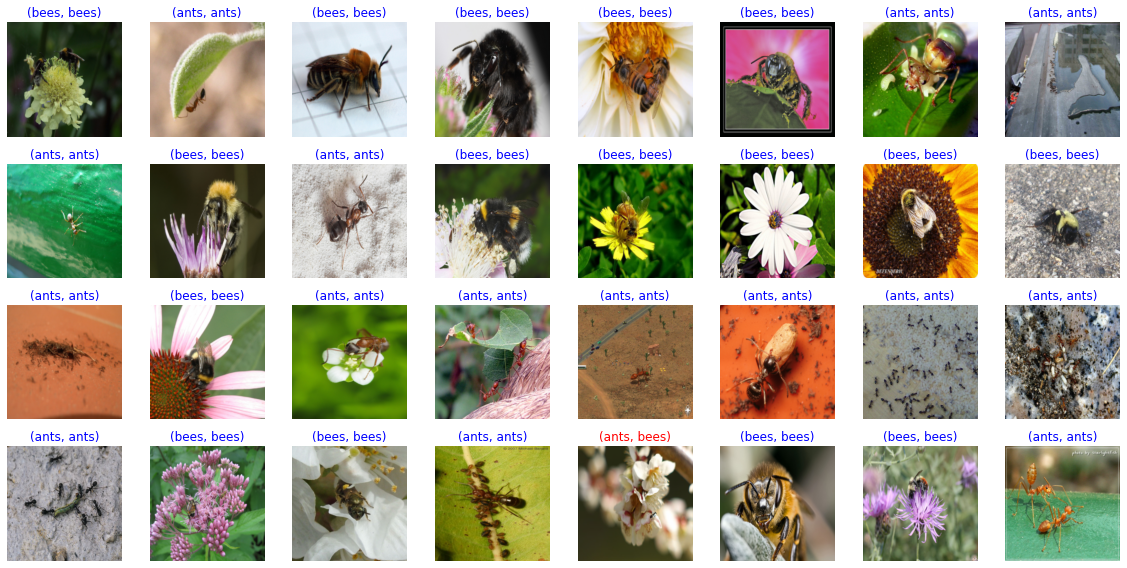

In [ ]:
#@title 検証用の画像に対する結果を例示します（このセルを実行する度に例が変わります）．val_acc最良の model_bestの場合
inputs, labels = next(iter(dataloaders['val']))
model_best.eval()
with torch.no_grad():
    outputs = model_best(inputs.to(device))

probabilities = nn.functional.softmax(outputs, dim=1)
_, preds = torch.max(probabilities, dim=1)

lbl_preds = [categories[l] for l in preds]
lbl_gts = [categories[l] for l in labels]
colors_arr = ['blue' if g== p else 'red' for g, p in zip(lbl_gts, lbl_preds)]

print("(ground truth, prediction)")
plotImages(inputs, ["(" + g + ", " + p + ")" for g, p in zip(lbl_gts, lbl_preds)], colors_arr=colors_arr, mean=hparam['mean_color'], std=hparam['std_color'])

(ground truth, prediction)


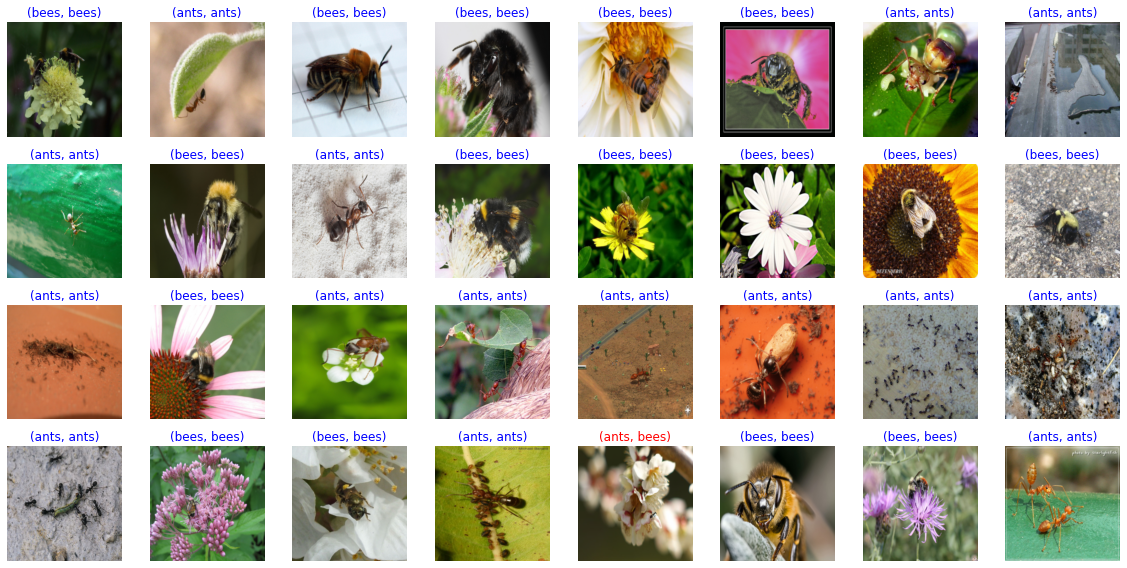

In [ ]:
#@title 検証用の画像に対する結果を例示します（このセルを実行する度に例が変わります）．epoch最後のmodelの場合
#inputs, labels = next(iter(dataloaders['val']))
model.eval()
with torch.no_grad():
    outputs = model(inputs.to(device))

probabilities = nn.functional.softmax(outputs, dim=1)
_, preds = torch.max(probabilities, dim=1)

lbl_preds = [categories[l] for l in preds]
lbl_gts = [categories[l] for l in labels]
colors_arr = ['blue' if g== p else 'red' for g, p in zip(lbl_gts, lbl_preds)]

print("(ground truth, prediction)")
plotImages(inputs, ["(" + g + ", " + p + ")" for g, p in zip(lbl_gts, lbl_preds)], colors_arr=colors_arr, mean=hparam['mean_color'], std=hparam['std_color'])

## モデルを保存します．

In [ ]:
#import time
#modelname = "MyModel" + time.strftime("%Y%m%d-%H%M%S") + ".pkl"
modelname = "model.pkl"

from google.colab import drive
drive.mount('/content/drive')
model_path="/content/drive/MyDrive/"
torch.save(model_best, model_path + modelname)